In [2]:
import os, sys

# Open a file
VCB_PATH = "/home/ubuntu/data/voxceleb1_wav"
names = [d for d in os.listdir(VCB_PATH) if os.path.isdir(os.path.join(VCB_PATH, d))]

audio_clips = {}
for name in names:
    audio_clips[name] = os.listdir(VCB_PATH + '/' + name)

names = sorted(names, key=lambda name : -len(audio_clips[name]))
print(names[:10])
print(audio_clips[names[0]])

['Rob_Reiner', 'Bob_Barker', 'Alan_Alda', 'Stephen_Fry', 'Louis_C.K.', 'Peter_Jackson', 'Vince_Gilligan', 'J.J._Abrams', 'Quentin_Tarantino', 'David_Attenborough']
['sOlWHKGy-SY_0000040.wav', 'lFEBeMFuL_M_0000098.wav', 'eWvntayRfe8_0000001.wav', 'xFTIClN5z70_0000040.wav', 'lFEBeMFuL_M_0000097.wav', 'eWvntayRfe8_0000029.wav', 'xFTIClN5z70_0000093.wav', 'lFEBeMFuL_M_0000091.wav', 'w7DmOHDIMQ8_0000039.wav', 'Hyck_yynhF4_0000008.wav', 'Vzqmi3MAixQ_0000066.wav', 'lFEBeMFuL_M_0000053.wav', 'eWvntayRfe8_0000045.wav', 'sOlWHKGy-SY_0000083.wav', 'xFTIClN5z70_0000012.wav', 'lFEBeMFuL_M_0000028.wav', 'Hyck_yynhF4_0000014.wav', 'lFEBeMFuL_M_0000001.wav', 'lFEBeMFuL_M_0000107.wav', 'xFTIClN5z70_0000076.wav', 'Vzqmi3MAixQ_0000095.wav', 'Hyck_yynhF4_0000055.wav', 'Hyck_yynhF4_0000050.wav', 'w7DmOHDIMQ8_0000096.wav', '6SBGrr4iFp0_0000039.wav', '4p9Fm05hlIM_0000009.wav', 'eWvntayRfe8_0000037.wav', 'xFTIClN5z70_0000014.wav', 'lFEBeMFuL_M_0000041.wav', 'w7DmOHDIMQ8_0000062.wav', 'Vu__sFrtFfY_0000004.wav'

In [22]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd

import librosa
import librosa.display

audio_path = '/'.join([VCB_PATH, names[0], audio_clips[names[0]][0]])
print(audio_path)
audio_path = '/'.join([VCB_PATH, 'Taylor_Swift', '5xvlDW_jd8U_0000001.wav'])
ipd.Audio(audio_path)

/home/ubuntu/data/voxceleb1_wav/Rob_Reiner/sOlWHKGy-SY_0000040.wav


(512, 250)
[   0.          145.31362915  149.73524475    0.          153.63502502
  148.35525513  136.42141724  160.5188446     0.          158.81228638
  162.40859985    0.          166.07046509  159.89025879  147.55419922
  166.75047302    0.          164.31468201  167.11096191    0.
  170.83015442  163.69543457  159.11636353  175.35774231    0.
  173.52470398  175.53964233    0.          185.41789246  177.25909424
  189.82077026  203.90020752    0.          210.39814758  211.64483643
    0.          213.71096802  204.43743896  188.35336304  200.70214844
    0.          182.2578125   182.74412537    0.          181.1204071
  170.61131287  168.06246948  178.95043945    0.          176.07394409
  175.80291748    0.          177.30334473  165.3924408   166.21469116
  175.82540894    0.          176.37261963  175.34259033    0.          183.2265625
  169.67358398  181.0411377   189.50634766    0.          200.90585327
  199.11024475    0.          213.27503967  197.70669556  203.23916626

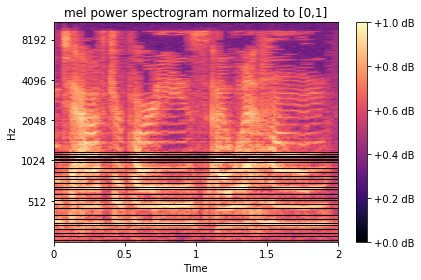

In [33]:
audio_path = '/'.join([VCB_PATH, 'Taylor_Swift', 'YqaVWHmGgtI_0000003.wav'])
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
import scipy.io.wavfile

sr = 16000 # sampling rate
n_mels = 512
n_fft = 1024
n_hop = 128

def get_audio(audio_path):
    rate, y = scipy.io.wavfile.read(audio_path)
    return y

# Spectrogram generation using Kapre https://github.com/keunwoochoi/kapre
def get_spectrogram(audio_path, normalize):
    y = get_audio(audio_path)[:16000*2]
    src = np.random.random((1, len(y)))
    model = Sequential()
    model.add(Melspectrogram(sr=sr, n_mels=n_mels, 
          n_dft=n_fft, n_hop=n_hop, input_shape=src.shape, power_melgram=1.0,
          return_decibel_melgram=True,
          trainable_kernel=False, name='melgram'))
    if normalize:
        model.add(Normalization2D(int_axis=2))
    n_ch, nsp_src = model.input_shape[1:]
    #src, _ = librosa.load(audio_path, sr=sr, mono=True)
    y = y[:nsp_src]
    y_batch = y[np.newaxis, np.newaxis, :]
    pred = model.predict(x=y_batch)
    if keras.backend.image_data_format == 'channels_first':
        S = pred[0, 0]
    else:
        S = pred[0, :, :, 0]
    log_S = S
    return log_S

log_S = get_spectrogram(audio_path, False)
mn = np.min(log_S)
mx = np.max(log_S)
log_S -= mn
log_S /= (mx - mn)

print(log_S.shape)
print(np.sum(log_S, axis =1))

normalized_log_S = get_spectrogram(audio_path, True);

print(np.max(np.abs(log_S - normalized_log_S)))

# Make a new figure
plt.figure(figsize=(6, 4))    
librosa.display.specshow(log_S, sr=sr, hop_length=n_hop, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram normalized to [0,1]')
plt.colorbar(format='%+02.1f dB')
plt.tight_layout()
plt.savefig('Taylor_1.png',dpi=300)

# # Make a new figure
# plt.figure(figsize=(12, 4))    
# librosa.display.specshow(normalized_log_S, sr=sr, hop_length=n_hop, x_axis='time', y_axis='mel')

# # Put a descriptive title on the plot
# plt.title('mel power spectrogram normalized to mean = 0, sd = 1')
# plt.colorbar(format='%+02.1f dB')
# plt.tight_layout()


In [7]:
NUM_PEOPLE = 10
AUDIO_LENGTH = 128 * 3 # Around 128 columns in spectrogram is one second
AUDIO_GAP = 128 // 2 # Gap of half a second
audio = []
speaker = []
for idx, name in enumerate(names[:NUM_PEOPLE]):
    print(name)
    num_clips = 0
    for audio_clip in audio_clips[name]:
        base_clip = get_audio('/'.join([VCB_PATH, name, audio_clip]))
        length = base_clip.shape[0]
        for start in range(0, length - AUDIO_LENGTH * n_mels + 1, AUDIO_GAP * n_mels):
            clip = [base_clip[start : start + (AUDIO_LENGTH * n_mels)]]
            audio += [clip]
            speaker += [np.reshape(np.eye(NUM_PEOPLE)[[idx]], NUM_PEOPLE)]

print(len(audio))
print(len(speaker))

Rob_Reiner


KeyboardInterrupt: 

In [ ]:
n = len(audio)
import random

asdf = list(zip(audio, speaker))
random.shuffle(asdf)
audio, speaker = list(map(list,zip(*asdf)))

In [ ]:
train_size = n // 2
val_size = n // 4
audio_train = np.array(audio[:train_size], dtype=float)
print(audio_train.shape)

speaker_train = np.array(speaker[:train_size], dtype=int)
print(speaker_train.shape)

audio_val = np.array(audio[train_size : train_size + val_size], dtype=float)
print(audio_val.shape)

speaker_val = np.array(speaker[train_size : train_size + val_size], dtype=int)
print(speaker_val.shape)

audio_test = np.array(audio[train_size + val_size:], dtype=float)
print(audio_test.shape)

speaker_test = np.array(speaker[train_size + val_size:], dtype=int)
print(speaker_test.shape)

In [ ]:
from keras.layers import *

HIDDEN_DIM = 128
LEARNING_RATE = 0.002

model = Sequential()
model.add(Melspectrogram(sr=sr, n_mels=n_mels, 
      n_dft=n_fft, n_hop=n_hop, input_shape=(1, AUDIO_LENGTH * n_mels), 
      return_decibel_melgram=True, power_melgram=2.0,
      trainable_kernel=False, name='melgram'))
model.add(Normalization2D(int_axis=0))
model.add(keras.layers.Reshape((n_mels, AUDIO_LENGTH)))
model.add(Permute((2, 1)))
model.add(LSTM(HIDDEN_DIM, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(NUM_PEOPLE, activation='softmax'))
rmsprop = keras.optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=rmsprop,
              loss='categorical_crossentropy', # loss function to be optimized
              metrics=['accuracy']) # doesn't affect optimization
model.fit(audio_train, speaker_train, validation_data=(audio_val, speaker_val), epochs=5, batch_size=256, shuffle=True)
model.summary()


In [ ]:
def evaluate(audio, speaker):
    scores = model.predict(audio, batch_size=256)
    return 1.0 * np.sum(np.argmax(scores, axis=1) - np.argmax(speaker, axis=1) == 0) / scores.shape[0]
def evaluate_top_k(audio, speaker, k=5):
    scores = model.predict(audio, batch_size=256)
    for i, score in enumerate(scores):
        sp = argmax(speaker[i])
        print(sum(score>score[sp]))

In [ ]:
print("Train:", evaluate(audio_train, speaker_train))

In [ ]:
print("Val:", evaluate(audio_val, speaker_val))

In [ ]:
print("Test:", evaluate(audio_test, speaker_test))

In [ ]:
num_audio_clips = 0
for name in names:
    num_audio_clips += len(audio_clips[name])
print(len(names))
print(num_audio_clips)